# Monte Carlo Portfolio Optimization

This notebook demonstrates how to use **Monte Carlo simulation** to construct and evaluate efficient portfolios. The objective is to simulate thousands of possible combinations of asset weights, calculate their expected return, volatility, and Sharpe ratio, and visualize the **efficient frontier**.

Monte Carlo simulation is commonly used in **quantitative finance** to assess the distribution of potential portfolio outcomes under uncertainty.

**Assets used**: AAPL, MSFT, GOOGL, META, AMZN  
**Period**: 2020-01-01 to 2024-12-31


We take a list of stocks and create a dataframe of each of their adjusted close data taken from Yahoo Finance given a certain training time period. In this project I have used data from 2020-2023 to find the optimal weights and I will test those weights on 2024 close data

In [32]:
import warnings
warnings.filterwarnings("ignore")

In [33]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Download historical prices
tickers = ['AAPL', 'MSFT', 'GOOGL', 'META', 'AMZN']
start_date = '2020-01-01'
end_date = '2023-12-31'

prices = yf.download(tickers, start=start_date, end=end_date)['Close']




[*********************100%***********************]  5 of 5 completed


## Building the Efficient Frontier

First, we find the covariance of returns matrix to see how much each asset changes with respect to the others. Here we are using log returns to calculate percentage change. The reason for this is that log returns are time addative:

If R13 is the returns for time between t3 and t1.
   R12 is the returns between t1 and t2 and
   R23 is the returns between t2 and t3.

$$ ln(R13)) = ln(R12))+ln(R23)) $$

The covariance of an asset with itself is the variance of that asset. If the covariance between two assets is positive, then their is a positive correlation between the assets, and if the covariance is negative, there is a negative correlation. If the covariance is 0, then there is no correlation between the assets

To get yearly expected returns we "resample" the data to be yearly and take the average yearly percent change to get the yearly expected returns for each stock

In [34]:
# Calculate log returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Annual statistics
annual_returns = log_returns.mean() * 252
cov_matrix = log_returns.cov() * 252

cov_matrix

Ticker,AAPL,AMZN,GOOGL,META,MSFT
Ticker,,,,,
AAPL,0.112583,0.079202,0.078245,0.095847,0.085360
AMZN,0.079202,0.141970,0.084356,0.109191,0.083697
GOOGL,0.078245,0.084356,0.112740,0.107540,0.084794
META,0.095847,0.109191,0.107540,0.225955,0.096519
MSFT,0.085360,0.083697,0.084794,0.096519,0.106476


The following formulas will be used to calculate portfolio variance and expected portfolio return:

$$\sigma^2(R_p) =  \sum\sum w_i w_j COV(R_i, R_j) $$
$$ 𝐸(𝑅_𝑝)=𝑤_1𝐸(𝑅_1)+𝑤_2𝐸(𝑅_2)+…..𝑤_𝑛𝐸(𝑅_𝑛)$$

In the simulation, 1,000,000 portfolios of random weights are created. The portfolio variance and expected portfolio return are then calculated using the formula above. The portfolio variance is then converted to annual standard deviation which will be used as the volatility using the following formula:

$$ Volatility = \sigma_(yearly) = sqrt(\sigma^2(R_p)*250) $$

(250 for 250 trading days a year)

In [35]:
# Simulate portfolios
num_portfolios = 1000000
num_assets = len(tickers)

results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    weights_record.append(weights)

    port_return = np.dot(weights, annual_returns)
    port_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
    sharpe_ratio = port_return / port_volatility

    results[0, i] = port_return
    results[1, i] = port_volatility
    results[2, i] = sharpe_ratio


In [36]:
# Build dataframe
results_df = pd.DataFrame({
    'Return': results[0],
    'Volatility': results[1],
    'Sharpe Ratio': results[2]
})
for i, ticker in enumerate(tickers):
    results_df[ticker + ' Weight'] = [w[i] for w in weights_record]

# Locate optimal Sharpe portfolio
max_sharpe_idx = results_df['Sharpe Ratio'].idxmax()
opt_portfolio = results_df.loc[max_sharpe_idx]


# Locate Minimum Volatility 
min_volatility_idx = results_df['Volatility'].idxmin()
min_volatility_portfolio = results_df.loc[min_volatility_idx]


In [37]:
opt_portfolio

Return          0.233456
Volatility      0.314001
Sharpe Ratio    0.743489
AAPL Weight     0.617751
MSFT Weight     0.005451
GOOGL Weight    0.006314
META Weight     0.007412
AMZN Weight     0.363073
Name: 612009, dtype: float64

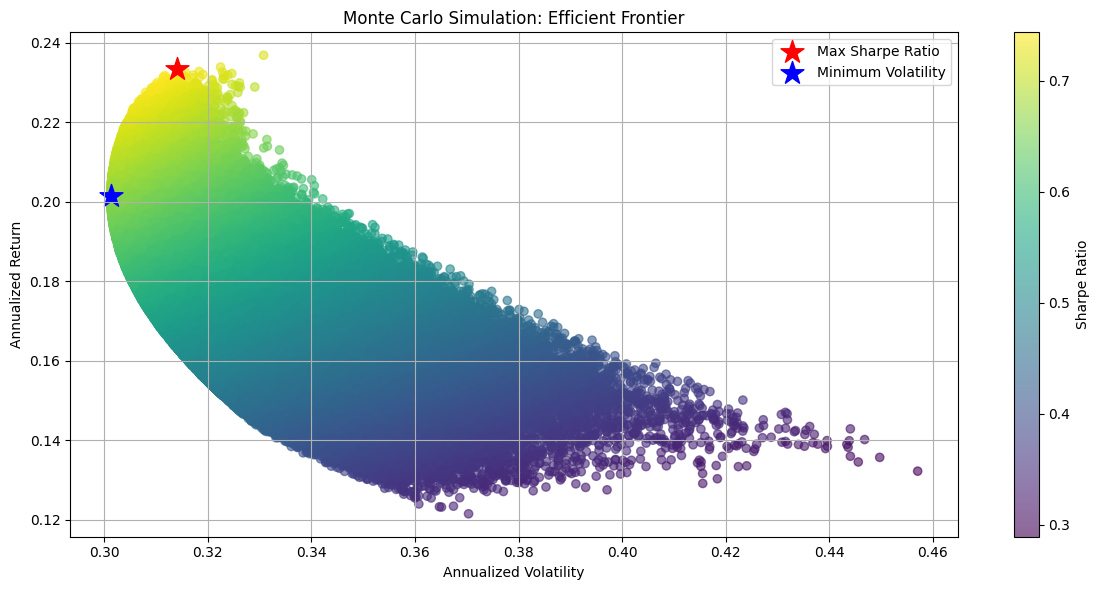

In [38]:
# Plot efficient frontier
plt.figure(figsize=(12, 6))
sc = plt.scatter(results_df['Volatility'], results_df['Return'],
                 c=results_df['Sharpe Ratio'], cmap='viridis', alpha=0.6)
plt.colorbar(sc, label='Sharpe Ratio')
plt.scatter(opt_portfolio['Volatility'], opt_portfolio['Return'], color='red',
            marker='*', s=300, label='Max Sharpe Ratio')
plt.scatter(min_volatility_portfolio['Volatility'], min_volatility_portfolio['Return'], color='blue',
            marker='*', s=300, label='Minimum Volatility')
plt.title('Monte Carlo Simulation: Efficient Frontier')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 🔁 Backtest of Optimal Portfolio

We now backtest the **maximum Sharpe ratio portfolio** selected from the Monte Carlo simulation.

We’ll compare it against:
- A **static equal-weighted portfolio** (i.e., each asset receives equal allocation)
- The **minimum volatility portfolio** on the Efficient Frontier
- A **buy-and-hold strategy using SPY** (proxy for market benchmark)

The backtest calculates cumulative returns for each strategy over time using the log returns.


[*********************100%***********************]  6 of 6 completed


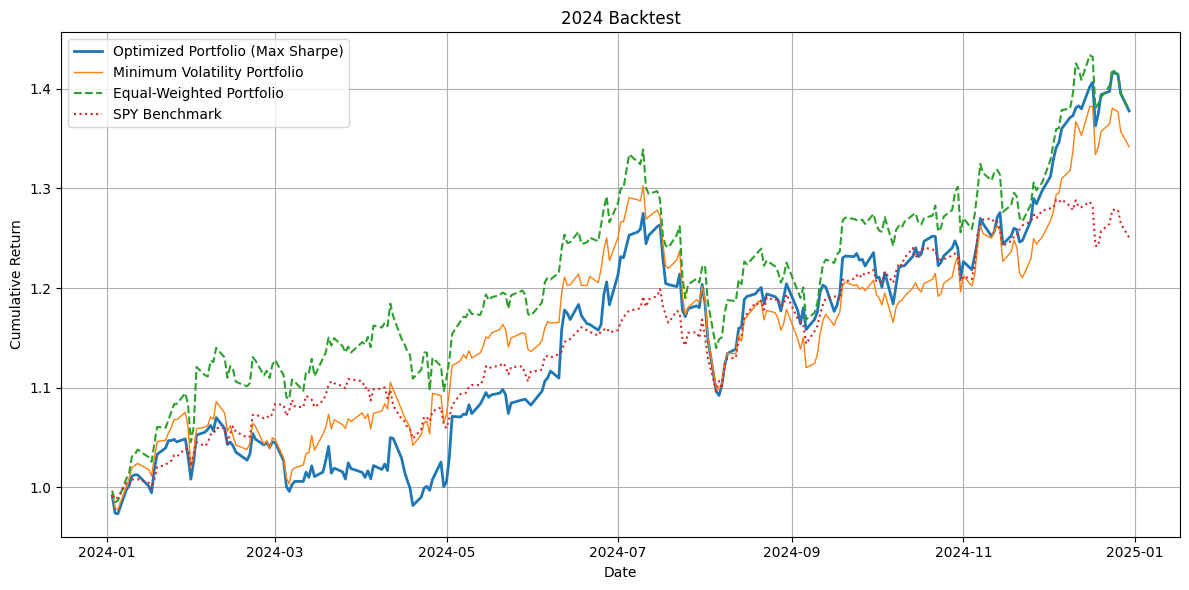

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

# Define 12-month period for 2024
backtest_start = "2024-01-01"
backtest_end = "2024-12-31"

# Download prices for tickers + SPY
prices_2024 = yf.download(tickers + ['SPY'], start=backtest_start, end=backtest_end)['Close']
log_returns_2024 = np.log(prices_2024 / prices_2024.shift(1)).dropna()

# Recompute cumulative returns over this short window
opt_weights = opt_portfolio[[col for col in opt_portfolio.index if 'Weight' in col]].values
min_vol_weights = min_volatility_portfolio[[col for col in min_volatility_portfolio.index if 'Weight' in col]].values
equal_weights = np.repeat(1 / len(tickers), len(tickers))

# Portfolio returns
opt_log_ret = log_returns_2024[tickers] @ opt_weights
min_vol_log_ret = log_returns_2024[tickers] @ min_vol_weights
eq_log_ret = log_returns_2024[tickers] @ equal_weights
spy_log_ret = log_returns_2024['SPY']

# Cumulative returns
opt_cum_ret = (1 + opt_log_ret).cumprod()
min_vol_cum_ret = (1 + min_vol_log_ret).cumprod()
eq_cum_ret = (1 + eq_log_ret).cumprod()
spy_cum_ret = (1 + spy_log_ret).cumprod()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(opt_cum_ret, label='Optimized Portfolio (Max Sharpe)', linewidth=2)
plt.plot(min_vol_cum_ret, label='Minimum Volatility Portfolio', linewidth=1)
plt.plot(eq_cum_ret, label='Equal-Weighted Portfolio', linestyle='--')
plt.plot(spy_cum_ret, label='SPY Benchmark', linestyle=':')
plt.title('2024 Backtest')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[*********************100%***********************]  6 of 6 completed


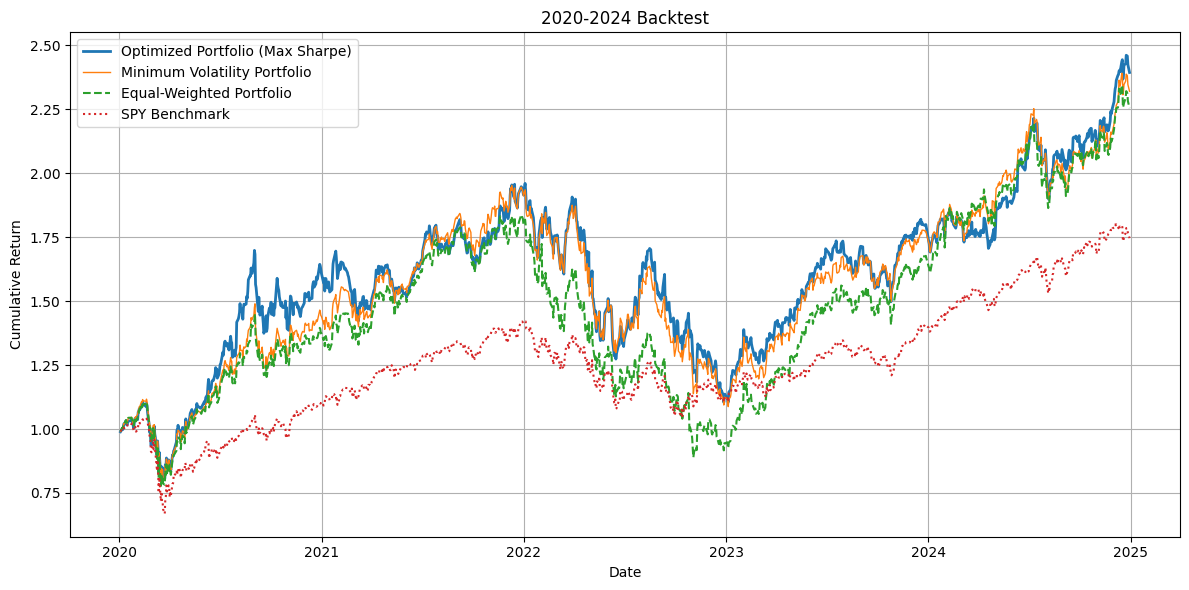

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

# Define backtest period
backtest_start = "2020-01-01"
backtest_end = "2024-12-31"

# Download prices for tickers + SPY
prices  = yf.download(tickers + ['SPY'], start=backtest_start, end=backtest_end)['Close']
log_returns  = np.log(prices  / prices .shift(1)).dropna()

# Recompute cumulative returns over this short window
opt_weights = opt_portfolio[[col for col in opt_portfolio.index if 'Weight' in col]].values
min_vol_weights = min_volatility_portfolio[[col for col in min_volatility_portfolio.index if 'Weight' in col]].values
equal_weights = np.repeat(1 / len(tickers), len(tickers))

# Portfolio returns
opt_log_ret = log_returns [tickers] @ opt_weights
min_vol_log_ret = log_returns [tickers] @ min_vol_weights
eq_log_ret = log_returns [tickers] @ equal_weights
spy_log_ret = log_returns ['SPY']

# Cumulative returns
opt_cum_ret = (1 + opt_log_ret).cumprod()
min_vol_cum_ret = (1 + min_vol_log_ret).cumprod()
eq_cum_ret = (1 + eq_log_ret).cumprod()
spy_cum_ret = (1 + spy_log_ret).cumprod()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(opt_cum_ret, label='Optimized Portfolio (Max Sharpe)', linewidth=2)
plt.plot(min_vol_cum_ret, label='Minimum Volatility Portfolio', linewidth=1)
plt.plot(eq_cum_ret, label='Equal-Weighted Portfolio', linestyle='--')
plt.plot(spy_cum_ret, label='SPY Benchmark', linestyle=':')
plt.title('2020-2024 Backtest')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
